# Определение перспективного тарифа для телеком компании 

В рамках данного проекта необходимо сравнить два тарифных плана для абонентов. Для этого, рассмотрим исходнные таблицы и подготовим данные для дальнейшего исследования. После этого, проанализируем информацию, сравним средние по группам пользователей тарифов и изучим гистограммы. В завершение, проверим две гипотезы о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, а также о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Этапы исследования проекта 

1. Общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy import stats as st

## 1. Общая информация

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [8]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [10]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Исходные датасеты говорят о следующем:
1. В датасете calls 202607 строк с записями о продолжительности каждого взятого звонка. Столбцы таблицы содержат информацию о датах звонков - call_date, их продолжительности - duration и принадлежности к определенному пользователю - user_id. В таблице встречаются нулевые значения. Вероятно, нулевые значения связаны с попыткой связаться с абонентом. Подобные значения не содержат в сеье информацию об опыте  использования тарифов пользователями, поэтому стоит их исключить после предварительной проверки;
2. В датасете internet 149396 строк с записями о трафике пользователей тарифов за определенный день. Столбцы таблицы указывают на дату создания трафика - session_date, количестве мегабайт - mb_used и о пользователе, который выполнил действие - user_id. В данной таблице также есть нулевые значения в столбце mb_used. Это, вероятно, связано с неудачными попытками соединения с серверами. Для анализа эффективности и опыта использования интернета такие данные могут быть полезны, но при изучении экономического результата от таких данных следует отказаться для полного понимания о количественных показателях трафика пользоваталей в тарифах;
3. В датасете messages 123036 строк с записями об отправленном сообщении пользователем. В таблице записана дата отправки сообщения - message_date и пользователь, который отправил сообщение - user_id;
4. Датасет tariffs содержит информацию о тарифных планах "Смарт" и "Ультра", абонентской стоимости, стоимости минуты, сообщения и гигабайта сверх тарифного плана;
4. Датасет users содержит информацию о пользователях компании, их имени и фамилии, даты подключения и города.

На втором этапе работы обработаем каждую таблицу для дальнейшего анализа и проверки гипотез

## 2. Подготовка данных

### 2.1 Привести к нужным типам 

Рассмторим исходные таблицы, приведем данные к логическому содержанию и условиям проекта

In [13]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [14]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


В таблице calls округлили значения продолжительности разговоров в соответствии с условиями компаии (в минуты в бОльшую сторону). Также перевели в нужный формат даты и выделили месяц из записи.
Теперь поработаем с данными в таблице internet

In [15]:
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Был исключен столбец Unnamed: 0, так как он дублировал индексы строк. Значения даты переведы в нужный формат и выделен месяц каждой отдельной сессии для дальнейшего анализа. Перейдем к messages

In [16]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


В таблице messages изменен формат столбца и выделен месяц, в который было отправлено сообщение. Таблица tariffs содержит информацию о двух тарифах и не требует предварительной обработки. Перейдем к таблице users

In [17]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Данные в таблицах приведены к соответствующим типам для дальнейшего анализа. Следующим этапом исправим некорректные значения в таблицах

### 2.2 Работа с ошибками

In [18]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [19]:
calls['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

В таблице Calls видны значения, равные 0. Вероятно, это неудачные попытки дозвониться абонентами. Рассмотрим, сколько таких значений в таблице

In [20]:
calls[calls['duration'] == 0]['duration'].count()

39613

Как видно, 39.6 тысяч звонков были продолжительностью 0 минут. Попробуем выявить зависимость нулевых значений от типа тарифа - целевого параметра проекта

In [21]:
calls_and_users = calls.merge(users, on='user_id', how='outer')

In [22]:
calls_sort_by_0 = calls_and_users[calls_and_users['duration'] == 0]

In [23]:
calls_sort_by_0.groupby('tariff')['duration'].count()

tariff
smart    25669
ultra    13944
Name: duration, dtype: int64

В данном случае взаимосвязи нет. Целью проекта является сравнение показателей активности пользователей тарифов "Смарт" и "Ультра". Так, в случае звонков продолжительностью 0 минут, мы не получаем информацию о активности, которая учитывается в абонентском плане и стоимостях минут за превышение плана. Если такие значения оставлять и заполнять другими значениями, например средней или медианой по группам, то результаты исследования будут искажены. В таком случае, отбросим нулевые значения звонков для чистоты анализа реальных вызовов

In [24]:
calls_none_zero = calls.query('duration > 0').reset_index(drop=True)

Перейдем к таблице internet. В значениях трафика также есть нулевые значения. Проверим, какое количество таких записей, есть ли зависимость от тарифов и обработаем значения

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [26]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [27]:
internet[internet['mb_used'] == 0]['mb_used'].count()

19598

In [28]:
internet_and_users = internet.merge(users, on='user_id', how='outer')

In [29]:
internet_sort_by_0 =internet_and_users[internet_and_users['mb_used'] == 0]

In [30]:
internet_sort_by_0.groupby('tariff')['mb_used'].count()

tariff
smart    17823
ultra     1775
Name: mb_used, dtype: int64

В данном случае также видно, что нулевые значения встречаются как в тарифе "Смарт", так и в тарифе "Ультра". В случае с сессиями, где было использовано 0 мб, логика замещения также отсутствует, как и в случае с звонками. Поэтому, отбросим нулевые значения для проверки реальных интернет-сессий

In [31]:
internet_none_zero = internet.query('mb_used > 0').reset_index(drop=True)

Таким образом, данные подготовлены для последующего анализа

### 2.3 Количество звонков и минут по месяцам 

In [32]:
calls_grouped = calls_none_zero.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=('sum', 'count'))
calls_grouped

count  sum
user_id month            
1000    5         17  159
        6         28  172
        7         41  340
        8         42  408
        9         46  466
...              ...  ...
1498    10        30  247
1499    9          8   70
        10        44  449
        11        62  612
        12        56  492

[3168 rows x 2 columns]

Количество и продолжительность звонков по пользователям за каждый месяц посчитаны

### 2.4 Количество отправленных сообщений по месяцам

In [33]:
messages_grouped = messages.pivot_table(
                    index=['user_id', 'month'], values='id', aggfunc='count')
messages_grouped

id
user_id month    
1000    5      22
        6      60
        7      75
        8      81
        9      57
...            ..
1498    10     42
1499    9      11
        10     48
        11     59
        12     66

[2717 rows x 1 columns]

Количество сообщений по пользователям за каждый месяц посчитаны

### 2.5 Объем израсходованного интернет-трафика по месяцам

In [34]:
internet_grouped = internet_none_zero.pivot_table(
                        index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_grouped

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3201 rows x 1 columns]

Объем трафика по пользователям за каждый месяц посчитаны

### 2.6 Помесячная выручка с каждого пользователя

Посчитаем выручку с каждого клиента исходя из следующей логики:
абонентская плата + ((минуты - минуты по тарифу) * стоимость) + ((сообщения - сообщения по тарифу) * стоимость) + ((трафик - трафик по тарифу) * стоимость)
Важно учесть, что если абонент не использовал полностью тарифный план, то не нужно учитывать остаток минут 

In [35]:
users_for_revenue = users[['user_id', 'city', 'tariff']]
users_for_revenue

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
...,...,...,...
495,1495,Иркутск,ultra
496,1496,Вологда,smart
497,1497,Челябинск,smart
498,1498,Владикавказ,smart


In [36]:
total_grouped = (calls_grouped
                 .merge(messages_grouped, on=('user_id', 'month'))
                 .merge(internet_grouped, on=('user_id', 'month')).reset_index(drop=False)
                 .merge(users_for_revenue, on='user_id')
                 .rename(columns={'user_id':'user_id', 'month':'month', 'count':'calls', 
                                  'sum':'minutes', 'id':'messages', 'mb_used':'mb'})
                )
total_grouped

,user_id,month,calls,minutes,messages,mb,city,tariff
0,1000,5,17,159,22,2253.49,Краснодар,ultra
1,1000,6,28,172,60,23233.77,Краснодар,ultra
2,1000,7,41,340,75,14003.64,Краснодар,ultra
3,1000,8,42,408,81,14055.93,Краснодар,ultra
4,1000,9,46,466,57,14568.91,Краснодар,ultra
...,...,...,...,...,...,...,...,...
2655,1498,10,30,247,42,20579.36,Владикавказ,smart
2656,1499,9,8,70,11,1845.75,Пермь,smart
2657,1499,10,44,449,48,17788.51,Пермь,smart
2658,1499,11,62,612,59,17963.31,Пермь,smart


In [37]:
def extra_mb(row):
    mb = row['mb']
    tariff = row['tariff']
    if tariff == 'smart':
        if mb > 15360:
            revenue = mb - 15360
        else:
            return 0
    elif tariff == 'ultra':
        if mb > 30720:
            revenue = mb - 30720
        else:
            return 0
    return revenue

In [38]:
total_grouped['extra_mb'] = total_grouped.apply(extra_mb, axis=1)
total_grouped

,user_id,month,calls,minutes,messages,mb,city,tariff,extra_mb
0,1000,5,17,159,22,2253.49,Краснодар,ultra,0.00
1,1000,6,28,172,60,23233.77,Краснодар,ultra,0.00
2,1000,7,41,340,75,14003.64,Краснодар,ultra,0.00
3,1000,8,42,408,81,14055.93,Краснодар,ultra,0.00
4,1000,9,46,466,57,14568.91,Краснодар,ultra,0.00
...,...,...,...,...,...,...,...,...,...
2655,1498,10,30,247,42,20579.36,Владикавказ,smart,5219.36
2656,1499,9,8,70,11,1845.75,Пермь,smart,0.00
2657,1499,10,44,449,48,17788.51,Пермь,smart,2428.51
2658,1499,11,62,612,59,17963.31,Пермь,smart,2603.31


In [39]:
def extra_minutes(row):
    minutes = row['minutes']
    tariff = row['tariff']
    if tariff == 'smart':
        if minutes > 500:
            revenue = minutes - 500
        else:
            return 0
    elif tariff == 'ultra':
        if minutes > 3000:
            revenue = minutes - 3000
        else:
            return 0
    return revenue

In [40]:
total_grouped['extra_minutes'] = total_grouped.apply(extra_minutes, axis=1)
total_grouped

,user_id,month,calls,minutes,messages,mb,city,tariff,extra_mb,extra_minutes
0,1000,5,17,159,22,2253.49,Краснодар,ultra,0.00,0
1,1000,6,28,172,60,23233.77,Краснодар,ultra,0.00,0
2,1000,7,41,340,75,14003.64,Краснодар,ultra,0.00,0
3,1000,8,42,408,81,14055.93,Краснодар,ultra,0.00,0
4,1000,9,46,466,57,14568.91,Краснодар,ultra,0.00,0
...,...,...,...,...,...,...,...,...,...,...
2655,1498,10,30,247,42,20579.36,Владикавказ,smart,5219.36,0
2656,1499,9,8,70,11,1845.75,Пермь,smart,0.00,0
2657,1499,10,44,449,48,17788.51,Пермь,smart,2428.51,0
2658,1499,11,62,612,59,17963.31,Пермь,smart,2603.31,112


In [41]:
def extra_messages(row):
    messages = row['messages']
    tariff = row['tariff']
    if tariff == 'smart':
        if messages > 50:
            revenue = messages - 50
        else:
            return 0
    elif tariff == 'ultra':
        if messages > 1000:
            revenue = messages - 1000
        else:
            return 0
    return revenue

In [42]:
total_grouped['extra_messages'] = total_grouped.apply(extra_messages, axis=1)
total_grouped

,user_id,month,calls,minutes,messages,mb,city,tariff,extra_mb,extra_minutes,extra_messages
0,1000,5,17,159,22,2253.49,Краснодар,ultra,0.00,0,0
1,1000,6,28,172,60,23233.77,Краснодар,ultra,0.00,0,0
2,1000,7,41,340,75,14003.64,Краснодар,ultra,0.00,0,0
3,1000,8,42,408,81,14055.93,Краснодар,ultra,0.00,0,0
4,1000,9,46,466,57,14568.91,Краснодар,ultra,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2655,1498,10,30,247,42,20579.36,Владикавказ,smart,5219.36,0,0
2656,1499,9,8,70,11,1845.75,Пермь,smart,0.00,0,0
2657,1499,10,44,449,48,17788.51,Пермь,smart,2428.51,0,0
2658,1499,11,62,612,59,17963.31,Пермь,smart,2603.31,112,9


In [43]:
def total_revenue(row):
    extra_mb = row['extra_mb']
    extra_minutes = row['extra_minutes']
    extra_messages = row['extra_messages']
    tariff = row['tariff']
    if tariff == 'smart':
        revenue = 550 + extra_mb*0.2 + extra_minutes*3 + extra_messages*3
    elif tariff == 'ultra':
        revenue = 1950 + extra_mb*0.15 + extra_minutes*1 + extra_messages*1
    return revenue

In [44]:
total_grouped['total_revenue'] = total_grouped.apply(total_revenue, axis=1)
total_grouped['total_revenue'] = np.ceil(total_grouped['total_revenue'])
total_grouped

,user_id,month,calls,minutes,messages,mb,city,tariff,extra_mb,extra_minutes,extra_messages,total_revenue
0,1000,5,17,159,22,2253.49,Краснодар,ultra,0.00,0,0,1950.0
1,1000,6,28,172,60,23233.77,Краснодар,ultra,0.00,0,0,1950.0
2,1000,7,41,340,75,14003.64,Краснодар,ultra,0.00,0,0,1950.0
3,1000,8,42,408,81,14055.93,Краснодар,ultra,0.00,0,0,1950.0
4,1000,9,46,466,57,14568.91,Краснодар,ultra,0.00,0,0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2655,1498,10,30,247,42,20579.36,Владикавказ,smart,5219.36,0,0,1594.0
2656,1499,9,8,70,11,1845.75,Пермь,smart,0.00,0,0,550.0
2657,1499,10,44,449,48,17788.51,Пермь,smart,2428.51,0,0,1036.0
2658,1499,11,62,612,59,17963.31,Пермь,smart,2603.31,112,9,1434.0


В результате, в ходе выполнения подготовки данных:
1. Данные в исходных таблицах приведены к нужному виду и обоснованы 
2. Исправлены ошибки в исходных таблицах, обработаны нулевые значения
3. Посчитаны ежемесячные показатели пользователе по минутам, звонкам, трафику и выручки. Данные выручки округлены для соответствия расчетов экономических результатов.

## 3. Проанализировать данные

###     3.1 Среднее, дисперсия и стандартное отклонение

Посчитаем средние значения, дисперсию и стандартное отклонение каждоый группе действий пользователей в каждом тарифе помесячно

In [45]:
total_grouped_smart = total_grouped.query('tariff == "smart"')
total_grouped_smart_mb = total_grouped_smart.pivot_table(index='month', values='mb', aggfunc=('mean', 'var', 'std'))
total_grouped_smart_mb

,mean,std,var
month,,,
1,8670.280000,6527.448579,4.260758e+07
2,11939.662000,5957.621284,3.549325e+07
3,14640.327391,5822.990558,3.390722e+07
4,13586.622316,5523.704842,3.051132e+07
5,16154.552131,5660.844794,3.204516e+07
6,15795.525816,5816.783284,3.383497e+07
7,15823.168793,5761.997127,3.320061e+07
8,16846.989257,5571.051331,3.103661e+07
9,16372.997387,5239.883170,2.745638e+07


In [46]:
total_grouped_smart = total_grouped.query('tariff == "smart"')
total_grouped_smart_messages = total_grouped_smart.pivot_table(index='month', values='messages', 
                                                               aggfunc=('mean', 'var', 'std'))
total_grouped_smart_messages

,mean,std,var
month,,,
1,19.733333,16.079401,258.547126
2,27.940000,20.987275,440.465714
3,35.550725,25.880117,669.780477
4,35.736842,22.842761,521.791713
5,39.032787,25.274014,638.775776
6,38.510638,27.133431,736.223100
7,38.988506,26.820747,719.352468
8,39.044554,27.664353,765.316413
9,39.252252,26.560260,705.447393


In [47]:
total_grouped_smart = total_grouped.query('tariff == "smart"')
total_grouped_smart_minutes = total_grouped_smart.pivot_table(index='month', values='minutes', 
                                                            aggfunc=('mean', 'var', 'std'))
total_grouped_smart_minutes

,mean,std,var
month,,,
1,217.700000,152.850874,23363.389655
2,311.740000,195.186233,38097.665714
3,393.086957,195.040851,38040.933504
4,385.610526,180.171272,32461.687122
5,399.606557,184.639007,34091.562932
6,399.177305,170.101074,28934.375481
7,409.321839,177.928185,31658.439173
8,429.460396,184.231119,33941.105389
9,429.135135,179.689274,32288.235050


In [48]:
total_grouped_ultra = total_grouped.query('tariff == "ultra"')
total_grouped_ultra_mb = total_grouped_ultra.pivot_table(index='month', values='mb',
                                                        aggfunc=('mean', 'var', 'std'))
total_grouped_ultra_mb

,mean,std,var
month,,,
1,13989.195714,5375.054821,2.889121e+07
2,14892.564286,11326.482811,1.282892e+08
3,17129.404800,10971.060749,1.203642e+08
4,16821.855789,8537.991870,7.289731e+07
5,19337.712128,9318.336826,8.683140e+07
6,18483.240794,8878.760006,7.883238e+07
7,20163.313971,9758.464548,9.522763e+07
8,19315.973537,9904.519671,9.809951e+07
9,19352.940000,9107.413444,8.294498e+07


In [49]:
total_grouped_ultra = total_grouped.query('tariff == "ultra"')
total_grouped_ultra_messages = total_grouped_ultra.pivot_table(index='month', values='messages',
                                                        aggfunc=('mean', 'var', 'std'))
total_grouped_ultra_messages

,mean,std,var
month,,,
1,43.428571,27.663798,765.285714
2,37.285714,25.694742,660.219780
3,47.800000,42.739521,1826.666667
4,45.447368,37.567739,1411.334993
5,51.042553,40.541421,1643.606846
6,50.888889,41.018922,1682.551971
7,60.044118,43.265730,1871.923398
8,57.707317,42.685901,1822.086119
9,62.539326,41.291936,1705.024004


In [50]:
total_grouped_ultra = total_grouped.query('tariff == "ultra"')
total_grouped_ultra_minutes = total_grouped_ultra.pivot_table(index='month', values='minutes',
                                                        aggfunc=('mean', 'var', 'std'))
total_grouped_ultra_minutes

,mean,std,var
month,,,
1,476.000000,266.287439,70909.000000
2,400.000000,331.112112,109635.230769
3,552.880000,369.606358,136608.860000
4,499.815789,270.602616,73225.775960
5,541.170213,283.091575,80140.839963
6,497.761905,311.202543,96847.023041
7,566.779412,295.952641,87587.965540
8,533.926829,307.905981,94806.093345
9,571.191011,309.760864,95951.792646


Следующим шагом наглядно рассмторим полученные результаты, сравним и опишем распределения

###     3.2 Гистограммы и распределения

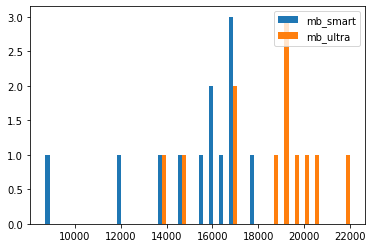

In [51]:
plt.hist([total_grouped_smart_mb['mean'], total_grouped_ultra_mb['mean']], bins=30, label=['mb_smart', 'mb_ultra'])
plt.legend(loc='upper right')
plt.show()

Распределение на гистограмме показывает, что в тарифе Смарт пользователи в среднем используют 14-17,5 гб в месяц, когда пользователи тарифа Ультра - от 17 до 22 гб в месяц

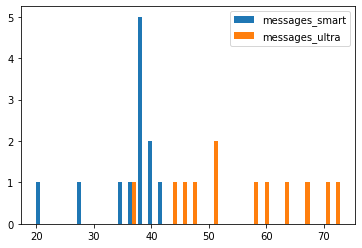

In [52]:
plt.hist([total_grouped_smart_messages['mean'], total_grouped_ultra_messages['mean']], 
         bins=30, label=['messages_smart', 'messages_ultra'])
plt.legend(loc='upper right')
plt.show()

Для пользоватеелей тарифа Смарт среднее количество сообщений в месяц находится около 40. У пользователей тарифа Ультра значения распределены в диапазоне от 38 до 75

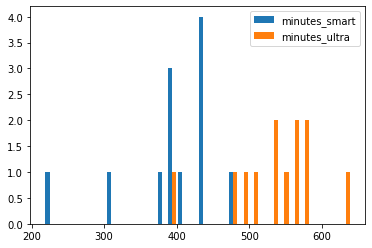

In [53]:
plt.hist([total_grouped_smart_minutes['mean'], total_grouped_ultra_minutes['mean']], 
         bins=30, label=['minutes_smart', 'minutes_ultra'])
plt.legend(loc='upper right')
plt.show()

Пользователи тарифа Смарт в среднем тратят от 370 до 470 минут, при этом в тарифе Ультра значения распределены между 500 и 650 минутами

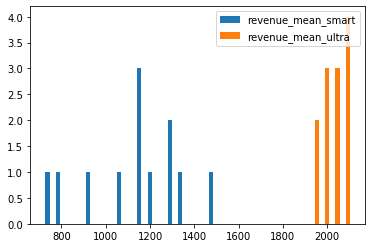

In [54]:
total_grouped_smart_revenue = total_grouped_smart.pivot_table(index='month', values='total_revenue', aggfunc='mean')
total_grouped_ultra_revenue = total_grouped_ultra.pivot_table(index='month', values='total_revenue', aggfunc='mean')

plt.hist([total_grouped_smart_revenue['total_revenue'], total_grouped_ultra_revenue['total_revenue']], 
         bins=30, label=['revenue_mean_smart', 'revenue_mean_ultra'])
plt.legend(loc='upper right')
plt.show()

Приведенная гистограмма показывает, как распределена средняя вырчука по тарифам за один месяц. Как видно из графика, выручка от тарифа "Смарт" более рассредоточенная и находится в диапазоне от 750 до 1500 рублей, тогда как у тарифа "Ультра" показатель находится в интервале 1950-2100 рублей

## 4. Проверка гипотез

### 4.1 Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается

Нулевая гипотеза: средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт"
Альтернативная гипотеза: средняя выручка пользователей тарифа "Ультра" не равна средней выручке пользователей тарифа "Смарт"

Уровень альфа 5%

In [55]:
sample_smart = total_grouped_smart['total_revenue']
sample_ultra = total_grouped_ultra['total_revenue']
alpha = .05

results_revenue = st.ttest_ind(sample_smart, sample_ultra)

print('Р-значение', results_revenue.pvalue)

if (results_revenue.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Р-значение 4.0794647582627034e-135
Отвергаем нулевую гипотезу


На основе полученных результатов выборки, следует предположить, что средняя выручка ГС пользователей тарифа "Ультра" не равна средней выручке ГС пользователей тарифа "Смарт" с уровнем значимости в 5%. Это потверждает полученные результаты среднемесячной выручки по тарифам на гистограммах

### 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза: средняя выручка пользователей из Москвы равна средней выручке пользователей других регионов
Альтернативная гипотеза: средняя выручка пользователей из Москвы не равна средней выручке пользователей других регионов

Уровень альфа 5%

In [56]:
sample_moscow = total_grouped.query('city == "Москва"')['total_revenue']
sample_non_moscow = total_grouped.query('city != "Москва"')['total_revenue']
alpha = .05

results_city = st.ttest_ind(sample_moscow, sample_non_moscow)

print('Р-значение', results_city.pvalue)

if (results_city.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Р-значение 0.09240418056212533
Не получилось отвергнуть нулевую гипотезу


На основе полученных результатов выборки, следует предположить, что средняя выручка ГС пользователей тарифа "Ультра" равна средней выручке ГС пользователей тарифа "Смарт" с уровнем значимости в 5%

## 5. Общий вывод

В результате выполнения проекта были получены следующие результаты:
1. Данные в исходных таблицах приведены к нужным типам, исправлены ошибки в значениях для получения достоверных результатов. Нулевые значения в таблицах calls и internet были удалены, так как информация в данных строках не влияет на цель проекта, которая заключается в определении экономического результата двух тарифов;
2. Посчитаны количество звонков и минут по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, а также помесячная выручка с каждого пользователя;
3. Проанализированны данные о количестве минут, сообщений и трафика для пользователей каждого тарифа в месяц, построены гистограммы;
4. По результатам проверки двух гипотез выдвинуто предположение, что с редняя выручка пользователей тарифов "Ультра" и "Смарт" не равна и выдвинуто предположение, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.